# Test pre-processing and annotation

- Crop medical image from other media based on four vertices
- Annotate tumour with marks of long and short axes

This notebook is partially built [this repo](https://github.com/aniruddhadave/Document-Scanner) and referred to the blog [link](https://blog.csdn.net/weixin_34023982/article/details/88860491) in Chinese.

(-0.5, 1499.5, 1124.5, -0.5)

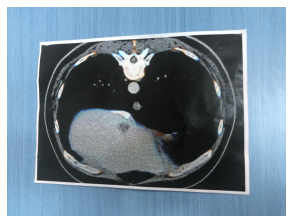

In [77]:
## read original image and resize with a proper resolution
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

origin_img_path = 'liver_scan1.jpg'
origin_im = cv2.imread(origin_img_path)
aspect_ratio = origin_im.shape[1]/origin_im.shape[0]
im = cv2.resize(origin_im, (1500, int(1500/aspect_ratio)))
im_copy = im.copy()

f, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(im)
ax.axis("off")

(-0.5, 1499.5, 1124.5, -0.5)

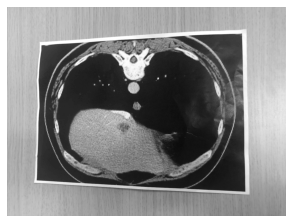

In [78]:
## convert color to grayscale
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

f, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(im_gray, cmap='gray')
ax.axis("off")

(-0.5, 1499.5, 1124.5, -0.5)

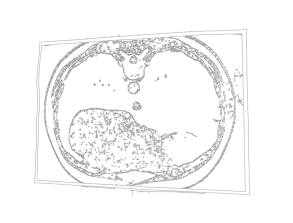

In [79]:
## Do Gaussian blur and detect edge
im_gray_blurred = cv2.GaussianBlur(im_gray, (11, 11), 0) # if fail, try this option
im_gray_blurred_edge = cv2.Canny(im_gray, 75, 200)

f, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(im_gray_blurred_edge, cmap='binary')
ax.axis("off")

(-0.5, 1499.5, 1124.5, -0.5)

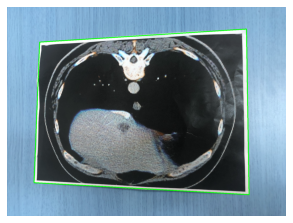

In [80]:
## Find four contours of image that have top-4 largest area.

_, cnts, _ = cv2.findContours(im_gray_blurred_edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5] # top 5 largest area
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#     print(approx)

    if len(approx) == 4:
        screenCnt = approx
        break
        
im_contours = cv2.drawContours(im_copy, [screenCnt], -1, (0, 255, 0), 3)
f, ax = plt.subplots(1,1,figsize=(5,5))
im_temp = ax.imshow(im_contours)
ax.axis("off")

In [81]:
def four_point_perspective_transform(image, pts):
    """
    Takes four points and generates a rectangular perspective
    transformation to get a top-down view of the image
    """
    # Order the points
    rect = sort_vertices(pts)
    (tl, tr, br, bl) = rect

    # Estimate the width of the new image
    # Max of width of top and bottom co-ordinates
    widthA = euclidean_distance(br, bl)
    widthB = euclidean_distance(tr, tl)
    maxWidth = max(int(widthA), int(widthB))

    # Estimate the height of the new image
    # Max of the height of left and right coordinates
    heightA = euclidean_distance(tr, br)
    heightB = euclidean_distance(tl, bl)
    maxHeight = max(int(heightA), int(heightB))

    # Estimate the destination points using the calculated dimensions
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Return the warped image
    return warped


def sort_vertices(pts):
    # Initialize a list of ordered co-ordinates (clockwise)
    vertices = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    # Top Left- Smallest Sum
    vertices[0] = pts[np.argmin(s)]
    # Bottom Right- Largest Sum
    vertices[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top Right- Smallest Difference
    vertices[1] = pts[np.argmin(diff)]
    # Bottom Left- Largest Difference
    vertices[3] = pts[np.argmax(diff)]

    # Return the clockwise ordered coordinates
    return vertices

def euclidean_distance(a,b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) **2)

[[3459  330]
 [ 470  518]
 [ 389 2542]
 [3497 2714]]


True

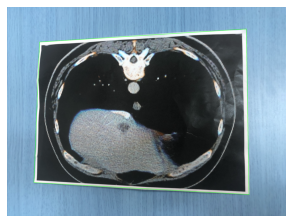

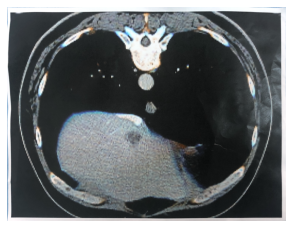

In [82]:
## Get the perspective transformation in the original space
# back to original image coordinate
screenCnt = screenCnt.reshape(4,2)
origin_screenCnt = np.zeros_like(screenCnt)
for idx, coord in enumerate(screenCnt):
    origin_screenCnt[idx] = np.array(coord) * np.array(origin_im.shape)[:2]/np.array(im.shape)[:2]
    origin_screenCnt[idx] = origin_screenCnt[idx].astype(int)

im_copy = origin_im.copy()
im_contours = cv2.drawContours(im_copy, [origin_screenCnt], -1, (0, 255, 0), 3)
f, ax = plt.subplots(1,1,figsize=(10,10))
im_temp = ax.imshow(im_contours)
ax.axis("off")    

print(origin_screenCnt)
warped_im = four_point_perspective_transform(origin_im, origin_screenCnt)
f, ax = plt.subplots(1,1,figsize=(5,))
im_temp = ax.imshow(warped_im)
ax.axis("off")   

cv2.imwrite(os.path.splitext(origin_img_path)[0]+'_scanned.png', warped_im)

(-0.5, 3111.5, 2383.5, -0.5)

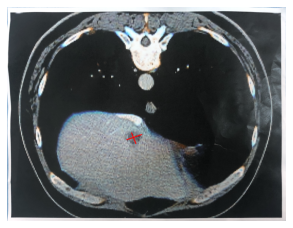

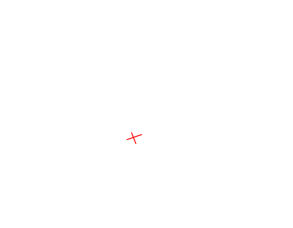

In [83]:
## Annotate tumor with long and short axes

origin_img_path = 'liver_scan1.jpg'
warped_im = cv2.imread(os.path.splitext(origin_img_path)[0]+'_scanned.png')

long_axis = {
    'start_point': (1337, 1477),
    'end_point': (1501, 1421),
    'color': (255, 0, 0),
    'thickness': 9
}

short_axis = {
    'start_point': (1389, 1401),
    'end_point': (1437, 1521),
    'color': (255, 0, 0),
    'thickness': 9
}

warped_im_recist = cv2.line(warped_im,
                            long_axis['start_point'],
                            long_axis['end_point'],
                            long_axis['color'],
                            long_axis['thickness'])
warped_im_recist = cv2.line(warped_im_recist,
                            short_axis['start_point'],
                            short_axis['end_point'],
                            short_axis['color'],
                            short_axis['thickness'])
f, ax = plt.subplots(1,1,figsize=(5,5))
im_temp = ax.imshow(warped_im_recist)
ax.axis("off")

white_im = np.ones_like(warped_im, dtype=np.uint8)*255

white_im_recist = cv2.line(white_im,
                            long_axis['start_point'],
                            long_axis['end_point'],
                            long_axis['color'],
                            long_axis['thickness'])
white_im_recist = cv2.line(white_im_recist,
                            short_axis['start_point'],
                            short_axis['end_point'],
                            short_axis['color'],
                            short_axis['thickness'])

f, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(white_im_recist)
ax.axis("off")